# Machine Learning Project

### By:
* Alanoud Alhakbani
* Abeer Alessa
* Elaf Almahmoud

### What is the project about?
Prediction of cardiovascular disease using Logistic Regression 

In [1]:
import numpy as np 
import pandas as pd
import math 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, learning_curve, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

## Dataset 

### Downloading&Splitting the dataset

In [2]:
#Load data
dataset = pd.read_csv("heart.csv")
dataset = pd.DataFrame(dataset)

#this will shaffule the data 
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Set the Features and Target variable
feature_cols = dataset.drop(['target'], axis = 1).columns
dataset_x = dataset[feature_cols]

dataset_x.insert(0, "x", np.ones(dataset_x.shape[0]), True)
dataset_y = dataset.target

# split the data into test/train
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(dataset_x, dataset_y, test_size=0.25)
display(train_set_x.shape, test_set_x.shape, train_set_y.shape, test_set_y.shape)

(227, 14)

(76, 14)

(227,)

(76,)

## Functions

In [13]:
def  normalizeFeatures(x1, x2):
    
    """
        input: x, the features matrix of size mXn as a pandas dataframe
        output: normalized feature matrix 
    """
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(x1)
    X_test_scaled = scaler.transform(x2)
    return X_train_scaled, X_test_scaled  

In [5]:
def sigmoid(x):
    """
        input: x
        output: sigmoid(x)
    """
    return 1/(1+np.exp(-x))

In [6]:
def computeLRCost(x, y, theta, lambdaa):
    """
        input: x,y,theta,lambda all numpy arrays, lambda number
        output: logistic regression cost J(theta) with regularization (number), theta gradiants (numpy array)
        
    """
    grad = []
    #x shape: (204,), theta shaep: (14,)
    hypothesis = sigmoid(np.dot(x,theta))
    error = (y*np.log(hypothesis)) + ((1-y)*np.log(1-hypothesis))
   
    cost = -sum(error)* 1/len(y)
    reg_cost = cost + lambdaa*sum(theta**2)
   

    t = hypothesis - y
    j_0 = sum(t)/len(y)
    grad.append(j_0)
    
    i = 1
    while(i<len(theta)):
        j = np.dot(x[:,i],t)/len(y) + (lambdaa/len(y))*theta[i]
        grad.append(j)
        i+=1
        
    grad = np.asarray(grad)
    return cost, grad

In [32]:
def learnLRTheta(x, y, lambdaa):
    """
        input: x,y,lambda 
        output: the best theta values for lambdaa value
    """
    theta = np.zeros(x.shape[1]) # n+1 thetas = 14
    lr = 0.03
    
    for i in range(9000): #check
        cost, grad = computeLRCost(x,y,theta,lambdaa)
        theta[0] = theta[0] - lr*grad[0]
        theta[1:] = theta[1:] - lr*(grad[1:]+((lambdaa/len(y))*theta[1:]))
        
        
    return theta

In [8]:
def trainLRModel(x, y, lambda_values):
    """
        input: x,y,lambda_valuse
        output: the theta values for the best lambdaa value
    """
    # losses for lambda values
    valid_loss = []
    train_loss = [] 
    # losses for each cross-val 
    train_scores = []
    valid_scores = []
    i = 1    
    for lambdaa in lambda_values:
        
        train_scores.clear()
        valid_scores.clear()
        
        #10 folds
        cv = KFold(n_splits=10, random_state=42, shuffle=False)
        for train_index, valid_index in cv.split(x):
            x_train, x_valid, y_train, y_valid = x[train_index], x[valid_index], y[train_index], y[valid_index]
            
            theta = learnLRTheta(x_train, y_train, lambdaa)

            loss, _ = computeLRCost(x_train, y_train, theta, lambdaa)
            train_scores.append(loss)
        
            loss, _ = computeLRCost(x_valid, y_valid, theta, lambdaa)
            valid_scores.append(loss)
            
        train_loss.append(np.mean(train_scores))
        valid_loss.append(np.mean(valid_scores))  
    

    lambda_val = valid_loss.index(min(valid_loss))
    theta = learnLRTheta(x,y,lambda_values[lambda_val])

    plt.plot(lambda_values, train_loss, 'b-', label="train")
    plt.plot(lambda_values, valid_loss, 'y-', label="valid")
    plt.ylabel('train/valid loss')
    plt.xlabel('lambda')
    plt.show()
    
    return theta, lambda_val

In [9]:
def predictClass(x, theta, threshold):
    
    y = []
    theta = theta.reshape(theta.shape[0],1)
    
    for i in range(len(x)):
        if sigmoid(np.dot(x[i],theta))>=threshold:
            y.append(1)
        else:
            y.append(0)

    return y

In [10]:
from sklearn.metrics import confusion_matrix

def testPerformance(y,y_predicted):
    
    cnf_matrix = confusion_matrix(y, y_predicted)
    print('Confusion Matrix: ')
    print(cnf_matrix)
    TN, FP, FN, TP = cnf_matrix.ravel()

    acc = (TP+TN)/cnf_matrix.sum()
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    #F Score
    F = 2*((PPV*TPR)/(PPV+TPR))
    
    return acc,TPR,PPV,F

## Preprocessing

In [17]:
train = train_set_x.to_numpy()
test = test_set_x.to_numpy()

train[0][0] = 0
test[0][0] = 0

X_train_scaled , X_test_scaled =  normalizeFeatures(train, test)

X_train_scaled[0][0] = 1
X_test_scaled[0][0] = 1

## Training

### Without feature normalization

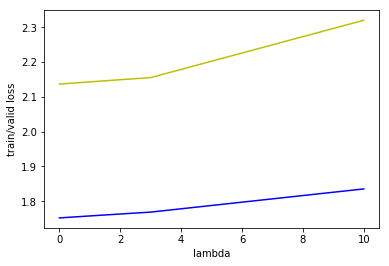

theta: [-0.01380483 -0.09776347 -0.23372718  0.54226925 -0.07499986 -0.02547868
  0.017748    0.05049134  0.12537963 -0.22769922 -0.43526359  0.16185747
 -0.48365323 -0.26895312]
lambda: 0


In [24]:
x1 = train_set_x.to_numpy()
y1 = train_set_y.to_numpy()

lambdaa_val = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10] 

theta1, lambda_val1 = trainLRModel(x1,y1,lambdaa_val)
print('theta: {}'.format(theta1))
print('lambda: {}'.format(lambda_val1))

### With feature normalization

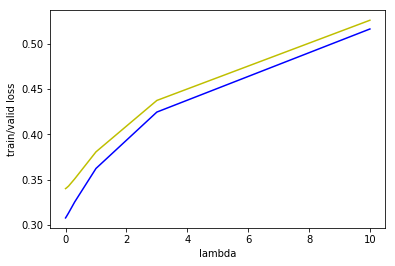

theta: [ 1.10437462 -0.93898694 -1.77571909  2.83510246 -0.90866312 -0.46196587
  0.15529814  0.55509277  2.00671396 -0.96331771 -1.6303991   2.03535347
 -3.68962668 -1.50952588]
lambda: 0


In [33]:
y2 = train_set_y.to_numpy()

lambdaa_val = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10] 

theta2, lambda_val2 = trainLRModel(X_train_scaled,y2,lambdaa_val)
print('theta: {}'.format(theta2))
print('lambda: {}'.format(lambda_val2))

## Testing

### Without feature normalization

In [25]:
x1 = test_set_x.to_numpy()
y1 = test_set_y.to_numpy()

y_pred1 = predictClass(x1, theta1, 0.5)
acc, TPR, PPV, F = testPerformance(y1, y_pred1)

print('Accuracy: {}'.format(acc))
print('TPR: {}'.format(TPR))
print('PPV: {}'.format(PPV))
print('F1: {}'.format(F))

Confusion Matrix: 
[[40  2]
 [18 16]]
Accuracy: 0.7368421052631579
TPR: 0.47058823529411764
PPV: 0.8888888888888888
F1: 0.6153846153846153


In [26]:
print('Confusion Matrix:')
print(confusion_matrix(y1, y_pred1))

# Calculates: accuracy, recall, precision, and f-score
print('Classification report')
print (classification_report(y1, y_pred1))

Confusion Matrix:
[[40  2]
 [18 16]]
Classification report
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        42
           1       0.89      0.47      0.62        34

   micro avg       0.74      0.74      0.74        76
   macro avg       0.79      0.71      0.71        76
weighted avg       0.78      0.74      0.72        76



### With feature normalization

In [34]:
y2 = test_set_y.to_numpy()

y_pred2 = predictClass(X_test_scaled, theta2, 0.5)
acc, TPR, PPV, F = testPerformance(y2, y_pred2)

print('Accuracy: {}'.format(acc))
print('TPR: {}'.format(TPR))
print('PPV: {}'.format(PPV))
print('F1: {}'.format(F))

Confusion Matrix: 
[[32 10]
 [ 9 25]]
Accuracy: 0.75
TPR: 0.7352941176470589
PPV: 0.7142857142857143
F1: 0.7246376811594202


In [35]:
print('Confusion Matrix:')
print(confusion_matrix(y2 , y_pred2))

# Calculates: accuracy, recall, precision, and f-score
print('Classification report')
print (classification_report(y2 , y_pred2))

Confusion Matrix:
[[32 10]
 [ 9 25]]
Classification report
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        42
           1       0.71      0.74      0.72        34

   micro avg       0.75      0.75      0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76

